<a href="https://colab.research.google.com/github/Ali-Asgar-Lakdawala/Book-Recommendation-System-capstone/blob/main/Team_Book_Recommendation_System_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Book Recommendation System </u></b>

## Problem Description
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such
web services, recommender systems have taken more and more place in our lives. From
e-commerce (suggest to buyers articles that could interest them) to online advertisement
(suggest to users the right contents, matching their preferences), recommender systems are
today unavoidable in our daily online journeys.
In a very general way, recommender systems are algorithms aimed at suggesting relevant
items to users (items being movies to watch, text to read, products to buy, or anything else
depending on industries).
Recommender systems are really critical in some industries as they can generate a huge
amount of income when they are efficient or also be a way to stand out significantly from
competitors. The main objective is to create a book recommendation system for users.



## Content

The Book-Crossing dataset comprises 3 files.
*  Users
Contains the users. Note that user IDs (User-ID) have been anonymized and map to
integers. Demographic data is provided (Location, Age) if available. Otherwise, these
fields contain NULL values.

*  Books
Books are identified by their respective ISBN. Invalid ISBNs have already been removed
from the dataset. Moreover, some content-based information is given (Book-Title,
Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web
Services. Note that in the case of several authors, only the first is provided. URLs linking
to cover images are also given, appearing in three different flavors (Image-URL-S,
Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the
Amazon website.

*  Ratings
Contains the book rating information. Ratings (Book-Rating) are either explicit,
expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit,
expressed by 0

---
# importing
---

In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
warnings.filterwarnings("ignore")
#to display all the graph in the workbook 
%matplotlib inline
sns.set_style("whitegrid",{'grid.linestyle': '--'})

In [2]:
# Set the display figure size using rcParams method 
sns.set(rc={'figure.figsize':(8,6)})
plt.rcParams['figure.figsize'] = [8,6]

In [3]:
# mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# setting up working directory path
woring_dir='/content/drive/MyDrive/Colab Notebooks/capstone unsup 1/data_book_recommendation/'

In [5]:
# creating data frame from csv files
books_df=pd.read_csv(woring_dir + 'Books.csv')
users_df=pd.read_csv(woring_dir + 'Users.csv')
ratings_df=pd.read_csv(woring_dir + 'Ratings.csv')


In [6]:
#checking for duplicate entries
print('duplicates in books = ',len(books_df)-len(books_df.drop_duplicates()))
print('duplicates in user = ',len(users_df)-len(users_df.drop_duplicates()))
print('duplicates in rating = ',len(ratings_df)-len(ratings_df.drop_duplicates()))

duplicates in books =  0
duplicates in user =  0
duplicates in rating =  0


---
# Dataset inspection & cleaning
---

## Books Data

In [7]:
# extracting top 5 observations
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [8]:
# Checking for null values
books_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            1
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

observation
* there are some nulll values which need to be treated

In [9]:
## Drop duplicate rows
users_df.drop_duplicates(keep='last', inplace=True)
users_df.reset_index(drop=True, inplace=True)

In [10]:
# droping the url columns 
books_df.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1, inplace=True)
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company


In [11]:
# finding the null values ni book author
books_df[books_df['Book-Author'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Perso...,NaN,1995,Edinburgh Financial Publishing


observation:

In Row 187689 there is null value for Book-Author


In [12]:
# finding the null values in publisher
books_df[books_df['Publisher'].isnull()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


Observation:
In Row 128890 , 129037  there is null value for Book-Author

In [13]:
# replacing the null values of book author and publisher with unknown
books_df['Book-Author'].fillna('Unknown',inplace=True)
books_df['Publisher'].fillna('Unknown',inplace=True)

In [14]:
# Checking for null values
books_df.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
dtype: int64

In [15]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271360 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271360 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


observation
* year of publication should be an integer lets check that 

In [16]:
# Checking for column Year-of-publication
books_df['Year-Of-Publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

observation
* has two text values and one two zero and some books that have future date of publication

In [17]:
# finding the books with Year-Of-Publication as 0
books_df[books_df['Year-Of-Publication'] == '0']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
196656,3442035368,Ich Gestehe,Heinz G. Konsalik,0,Wilhelm Goldmann Verlag GmbH
196678,0553124803,Being There,Jerzy Kosinski,0,Bantam Doubleday Dell
196680,888274387X,Vaniglia E Cioccolato,Modignani Casati,0,Sperling Paperback
196685,033368155X,Surreal Lives the Surrealists 1945,Ruth Brandon,0,Humanity Press/prometheus Bk
196734,0207158452,Games of the Strong,Glenda Adams,0,Harpercollins Publisher
...,...,...,...,...,...
261929,0760700702,100 Great Archaeological Discoveries,Paul G Bahn,0,Barnes Noble Inc
261930,0760701962,UFO's: A Scientific Debate,Carl Sagan,0,Barnes Noble Books
261931,0760706379,Only Way to Cross,John Maxtone Graham,0,Barnes Noble
262120,0880292288,New York Times Guide to Reference Materials,Mona Mccormick,0,Dorset House Publishing Co Inc


In [18]:
# finding the books with Year-Of-Publication as DK Publishing Inc
books_df[books_df['Year-Of-Publication'] == 'DK Publishing Inc']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Beg...",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.0...
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Book...",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.0...


observation:

Here we can see that book-author  and year of publication column are mistyped so we need to correct the column value by interchanging these value.


In [19]:
# finding the books with Year-Of-Publication as Gallimard
books_df[books_df['Year-Of-Publication'] == 'Gallimard']

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-M...",2003,Gallimard,http://images.amazon.com/images/P/2070426769.0...


observation:

Here we can see that book-author and year of publication column are mistyped so we need to correct the column value by interchanging these value.

In [20]:
# finding the book title of the following publisher
list(books_df[(books_df['Year-Of-Publication'] == 'DK Publishing Inc')|( books_df['Year-Of-Publication'] == 'Gallimard')]['Book-Title'])

['DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\\";Michael Teitelbaum"',
 'Peuple du ciel, suivi de \'Les Bergers\\";Jean-Marie Gustave Le ClÃ?Â©zio"',
 'DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\\";James Buckley"']

In [21]:
# replacing all suspicios data to relavent data 
books_df.at[209538 ,'Publisher'] = 'DK Publishing Inc'
books_df.at[209538 ,'Year-Of-Publication'] = 2000
books_df.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)'
books_df.at[209538 ,'Book-Author'] = 'Michael Teitelbaum'

books_df.at[221678 ,'Publisher'] = 'DK Publishing Inc'
books_df.at[221678 ,'Year-Of-Publication'] = 2000
books_df.at[209538 ,'Book-Title'] = 'DK Readers: Creating the X-Men, How Comic Boofksf Come to Life (Level 4: Proficient Readers)'
books_df.at[209538 ,'Book-Author'] = 'James Buckley'

books_df.at[220731 ,'Publisher'] = 'Gallimard'
books_df.at[220731 ,'Year-Of-Publication'] = 2003
books_df.at[209538 ,'Book-Title'] = 'Peuple du ciel - Suivi de Les bergers '
books_df.at[209538 ,'Book-Author'] = 'Jean-Marie Gustave Le ClÃ?Â©zio'

In [22]:
# converting the data type
books_df['Year-Of-Publication'] = books_df['Year-Of-Publication'].astype(int)

In [23]:
from datetime import date
# finding the current year
current_year = date.today().year
print(current_year)

2021


In [24]:
# finding books with date of publication greater than current date 
books_df.loc[(books_df['Year-Of-Publication'] > current_year)]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
37487,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030,Aladdin
55676,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030,Aladdin
78168,0870449842,Crossing America,National Geographic Society,2030,National Geographic
80264,0140301690,Alice's Adventures in Wonderland and Through t...,Lewis Carroll,2050,Puffin Books
97826,0140201092,Outline of European Architecture (Pelican S.),Nikolaus Pevsner,2050,Penguin USA
116053,0394701658,Three Plays of Eugene Oneill,Eugene O'Neill,2038,Vintage Books USA
118294,3442436893,Das groÃ?Â?e BÃ?Â¶se- MÃ?Â¤dchen- Lesebuch.,Kathy Lette,2026,Goldmann
192993,0870446924,"Field Guide to the Birds of North America, 3rd...",National Geographic Society,2030,National Geographic
228173,0671266500,FOREST PEOPLE (Touchstone Books (Hardcover)),Colin M. Turnbull,2030,Simon &amp; Schuster
240169,0684718022,In Our Time: Stories (Scribner Classic),Ernest Hemingway,2030,Collier Books


In [25]:
# replacing year of publication 0 and greater than 2021 to mean of the data set 
books_df.loc[(books_df['Year-Of-Publication'] > 2021) | (books_df['Year-Of-Publication'] == 0),'Year-Of-Publication'] = np.nan
books_df.fillna(round(books_df['Year-Of-Publication'].mean()),inplace=True)

In [26]:
# Checking for column Year-of-publication
books_df['Year-Of-Publication'].describe()

count    271360.000000
mean       1993.693241
std           8.249980
min        1376.000000
25%        1989.000000
50%        1995.000000
75%        2000.000000
max        2021.000000
Name: Year-Of-Publication, dtype: float64

In [27]:
#checking info of book_df
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 271360 non-null  object 
 1   Book-Title           271360 non-null  object 
 2   Book-Author          271360 non-null  object 
 3   Year-Of-Publication  271360 non-null  float64
 4   Publisher            271360 non-null  object 
dtypes: float64(1), object(4)
memory usage: 10.4+ MB


## User Data

In [28]:
# extracting top 5 observations
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [29]:
users_df.shape

(278858, 3)

In [30]:
# Checking null values
print(users_df.isna().sum())

User-ID          0
Location         0
Age         110762
dtype: int64


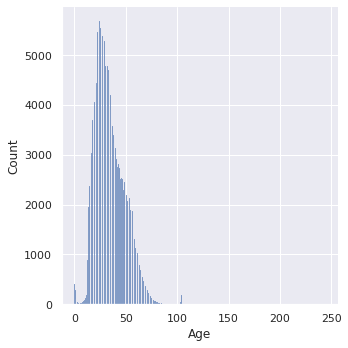

In [31]:
sns.displot(users_df.Age)

* there are few people which are above 100 age which might be outliers 

## Ratings Data

In [32]:
# extracting top 5 observations
ratings_df.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [33]:
# Checking for null values
ratings_df.isnull().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

Observation:

No null value in rating_df

In [34]:
# combning all the data frames
df = pd.merge(books_df, ratings_df, on='ISBN', how='inner')
df = pd.merge(df, users_df, on='User-ID', how='inner')
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",NaN


In [35]:
# finding the unique locations 
df['Location'].str.split(',', expand=True)[3].unique()

array([None, ' usa', ' united kingdom', ' philippines', ' france',
       'guishan li', ' canada', ' guam-dong', ' nigeria', ' indonesia',
       ' japan', ' georgia', ' spain', ' south korea', '', ' iceland',
       ' kansas', ' ireland', ' greece"', ' new zealand', ' malaysia',
       ' portugal', ' british columbia', ' italy', ' ontario', ' finland',
       ' singapore', ' germany', ' channel islands', ' tobago',
       ' austria', ' afghanistan', ' australia', ' deutschland',
       ' switzerland', ' mexico', ' galiza', ' c.a.', ' denmark',
       ' china', ' guam', ' cape verde', ' honduras', ' united states',
       'italy', ' disgruntled states of america', ' england', ' the',
       ' rhode island', ' netherlands', ' gifu', ' the world tomorrow'],
      dtype=object)

# Data Visualization

## Uni Variate Analysis

In [36]:
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",NaN


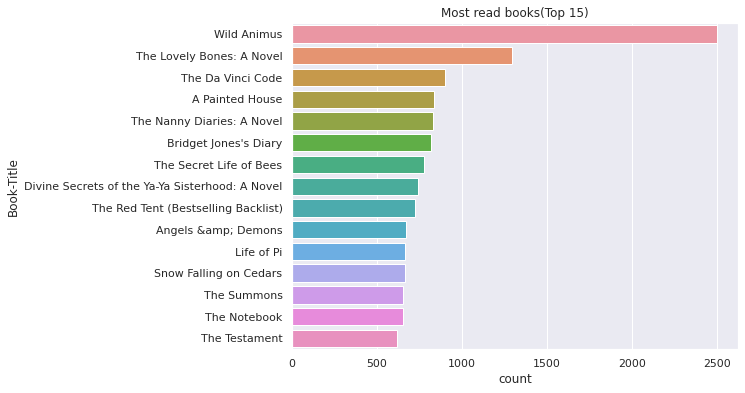

In [37]:
#  ploting graph of most read books 
sns.countplot(y="Book-Title", data=df, order=df['Book-Title'].value_counts().index[0:15])
plt.title("Most read books(Top 15)")
plt.show()

In [38]:
df['Book-Title'].value_counts().count()

241071

Observation

* We have 241071 unique Book Title.
* The most read book is WIld animus with almost 2500 reads


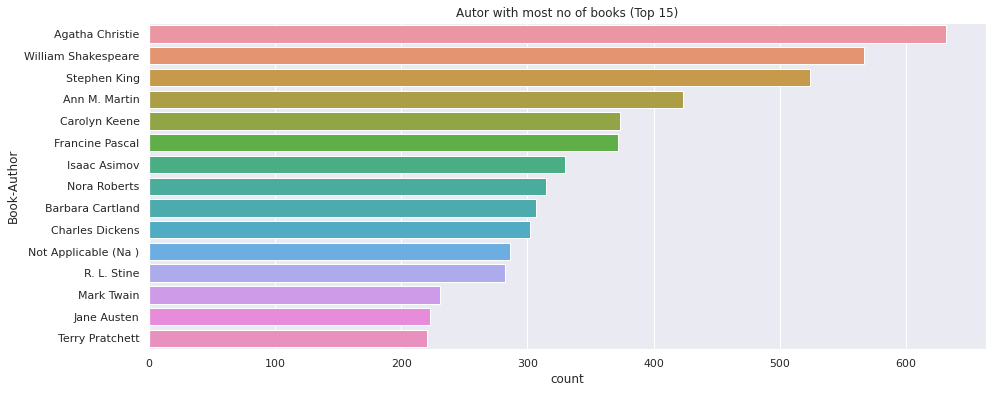

In [39]:
# plot of top 15 authors with most no of books
plt.figure(figsize=(15,6))
sns.countplot(y="Book-Author", data=books_df,order=books_df['Book-Author'].value_counts().index[0:15])
plt.title("Autor with most no of books (Top 15)")
plt.show()

observation
* the author with most no of boks is agatha cristie with almost 650 books

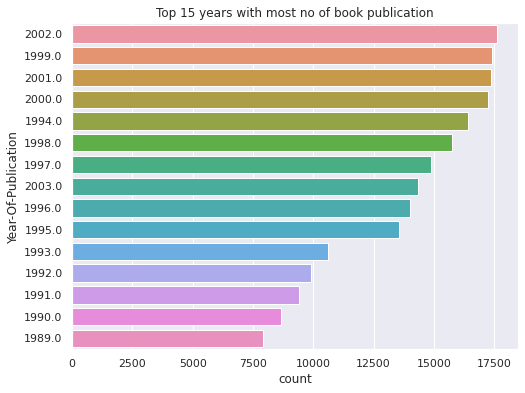

In [40]:
# plot for most no of books publised in a year
sns.countplot(y="Year-Of-Publication", data=books_df,order=books_df['Year-Of-Publication'].value_counts().index[:15])
plt.title('Top 15 years with most no of book publication')
plt.show()

* most of the books are published between 1999 and 2002

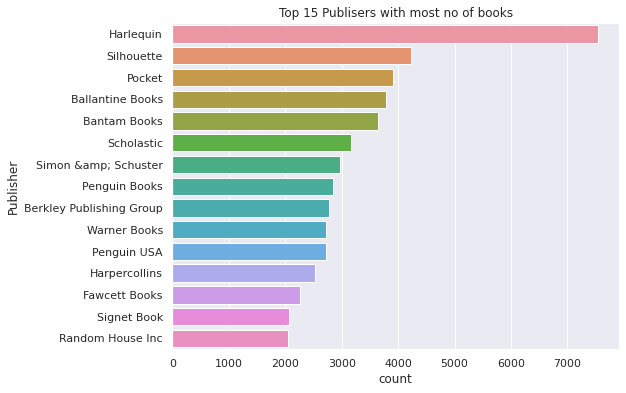

In [41]:
sns.countplot(y="Publisher", data=books_df,order=books_df['Publisher'].value_counts().index[0:15])
# setting title
plt.title('Top 15 Publisers with most no of books')
plt.show()

observation:

* we have total 16805 Unique "Publisher"
* Publisher "Harlequin" has published most no of books almost 7535

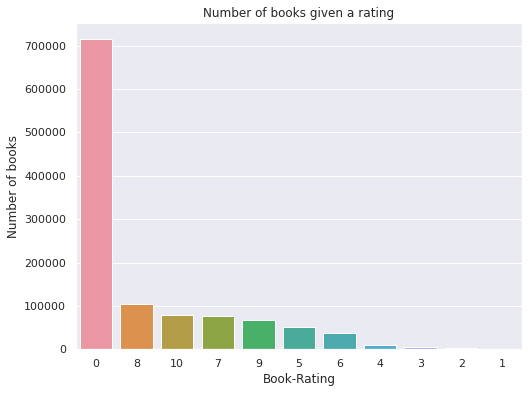

In [42]:
sns.countplot(x="Book-Rating", data=ratings_df,order=ratings_df['Book-Rating'].value_counts().index[:])
# setting title
plt.title('Number of books given a rating')
# setting lables for y axis
plt.ylabel('Number of books')
plt.show()

In [43]:
ratings_df['Book-Rating'].value_counts()

0     716109
8     103736
10     78610
7      76457
9      67541
5      50974
6      36924
4       8904
3       5996
2       2759
1       1770
Name: Book-Rating, dtype: int64

observation 
* more than 700000 books have 0 rating 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text major ticklabel objects>)

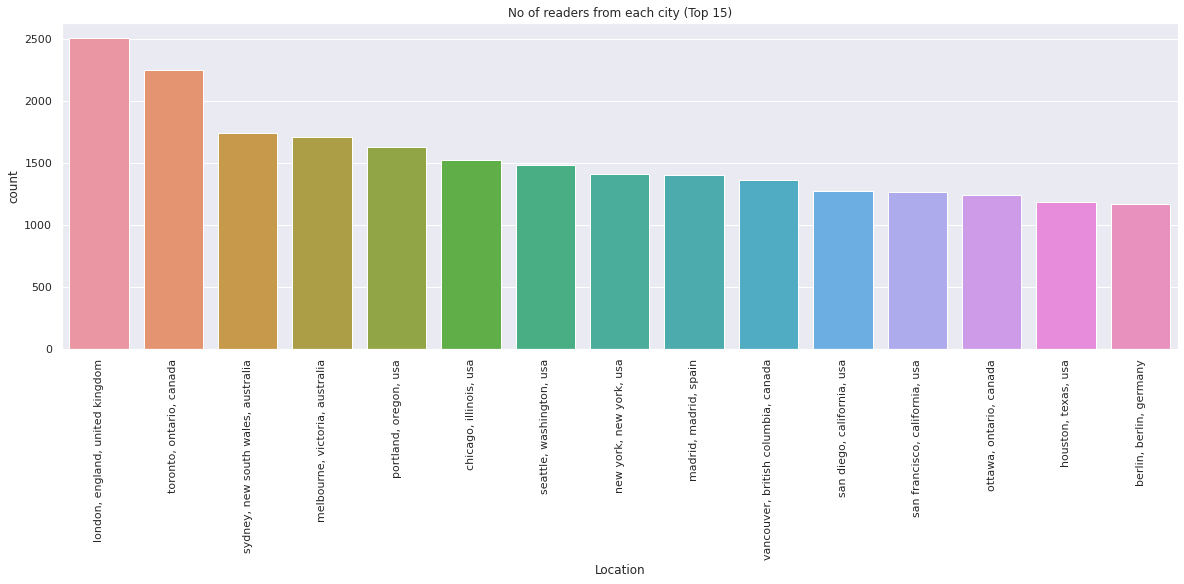

In [44]:
#ploting the location count
plt.figure(figsize=(20,6))
sns.countplot(x="Location", data=users_df,order=users_df['Location'].value_counts().index[0:15])
plt.title("No of readers from each city (Top 15)")
plt.xticks(rotation=90)

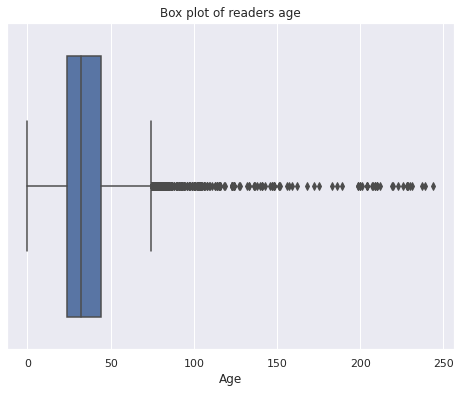

In [45]:
# Checking the Outliers in Age.
sns.boxplot(users_df.Age)
# setting title
plt.title('Box plot of readers age')
plt.show()

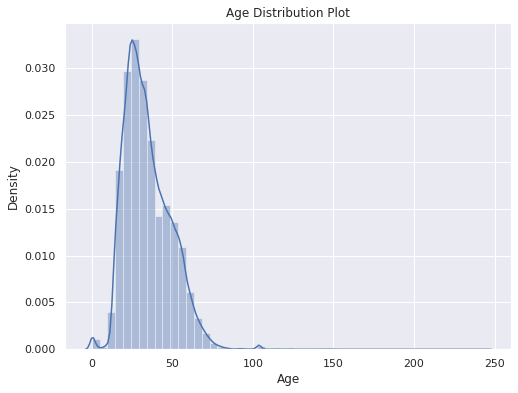

In [46]:
#ploting Distribution polt for age column
sns.distplot(users_df.Age)
# setting title
plt.title('Age Distribution Plot')
plt.show()

observation 
* some users age is more than 100 wich is a outlier 

In [47]:
# First we are filling the nan value where the age is greater than 90 and less than 8 then replacing the nan with mean value.
users_df.loc[(users_df['Age'] > 100) | (users_df['Age'] < 5), 'Age']= np.NAN
users_df['Age']= users_df['Age'].fillna((users_df['Age'].mean()))

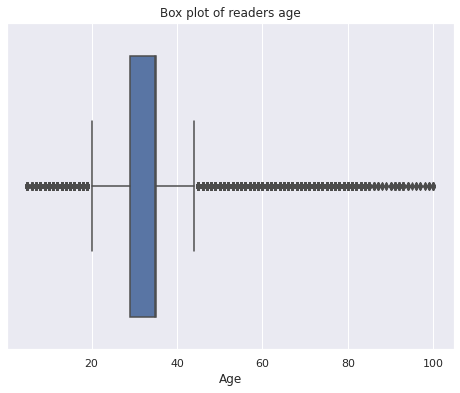

In [48]:
sns.boxplot(users_df.Age)
# setting title
plt.title('Box plot of readers age')
plt.show()


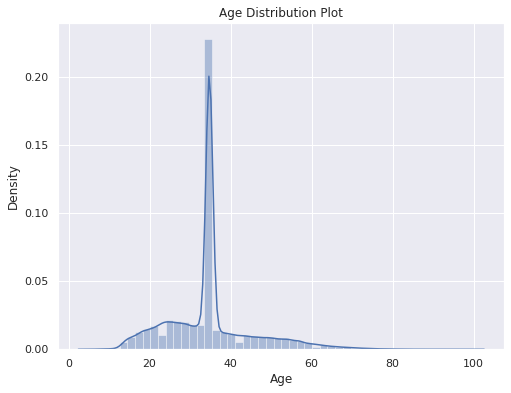

In [49]:
#ploting Distribution polt for age column
sns.distplot(users_df.Age)
# setting title
plt.title('Age Distribution Plot')
plt.show()

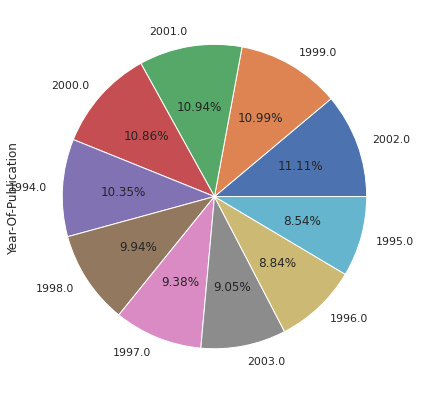

In [50]:
fig= plt.figure(figsize=(15,7))
books_df['Year-Of-Publication'].value_counts().head(10).plot(kind='pie', autopct='%1.2f%%')
plt.show()

**observation**

Most of the book published on 2002

In [51]:
from wordcloud import WordCloud

In [52]:
temp_df_books=df.groupby('Book-Title').agg({'Book-Rating':'mean','Book-Title':'count'}).rename(columns={'Book-Title':'count','Book-Rating':'avg_Book_Rating'}).reset_index()

In [53]:
temp_df_books=temp_df_books[temp_df_books['count']>100]

(-0.5, 1599.5, 1999.5, -0.5)

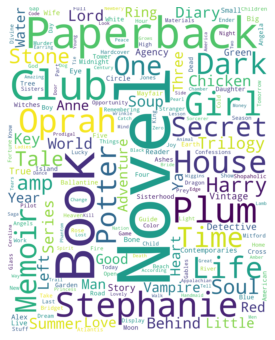

In [54]:
#Creating the text variable

text = " ".join(name for name in temp_df_books.sort_values('avg_Book_Rating',ascending=False)['Book-Title'][:500])


# Creating word_cloud with text as argument in .generate() method

word_cloud = WordCloud(width = 1600, height = 2000,collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")

(-0.5, 1599.5, 1999.5, -0.5)

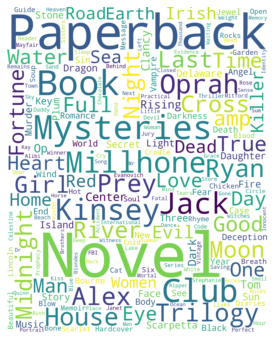

In [55]:
#Creating the text variable

text = " ".join(name for name in temp_df_books.sort_values('avg_Book_Rating',ascending=False)['Book-Title'][-500:])


# Creating word_cloud with text as argument in .generate() method

word_cloud = WordCloud(width = 1600, height = 2000,collocations = False, background_color = 'white').generate(text)

# Display the generated Word Cloud

plt.imshow(word_cloud, interpolation='bilinear')

plt.axis("off")

## bi variate

In [59]:
age_rating=df.groupby('Age')['Book-Rating'].mean().reset_index()
# First we are filling the nan value where the age is greater than 90 and less than 8 then replacing the nan with mean value.
age_rating.loc[(age_rating['Age'] > 100) | (age_rating['Age'] < 5), 'Age']= np.NAN
age_rating['Age']= age_rating['Age'].fillna(round(age_rating['Age'].mean()))
age_rating.head()

,Age,Book-Rating
0,51.0,2.859180
1,51.0,3.464953
2,51.0,4.214953
3,51.0,4.923077
4,51.0,4.630996


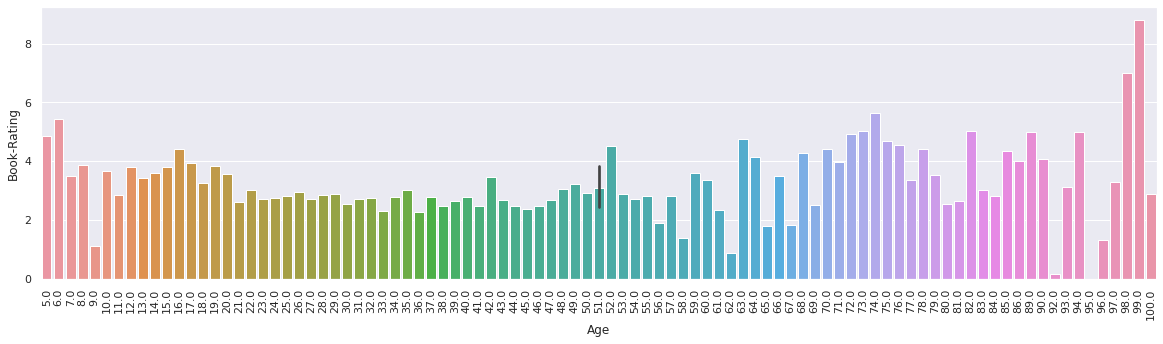

In [60]:
plt.figure(figsize=(20,5))
sns.barplot(x=age_rating['Age'],y=age_rating['Book-Rating'])
plt.xticks(rotation=90)
plt.show()


In [61]:
temp_df_books.sort_values('avg_Book_Rating',ascending=False).head(15)

,Book-Title,avg_Book_Rating,count
80433,Harry Potter and the Prisoner of Azkaban (Book 3),5.852804,428
80421,Harry Potter and the Goblet of Fire (Book 4),5.824289,387
195672,The Little Prince,5.815603,141
80440,Harry Potter and the Sorcerer's Stone (Book 1),5.737410,278
80425,Harry Potter and the Order of the Phoenix (Boo...,5.501441,347
60581,Ender's Game (Ender Wiggins Saga (Paperback)),5.409639,249
80413,Harry Potter and the Chamber of Secrets (Book 2),5.183453,556
201970,The Perks of Being a Wallflower,5.144231,104
191612,The Hobbit : The Enchanting Prelude to The Lor...,5.007117,281
187377,The Fellowship of the Ring (The Lord of the Ri...,4.948370,368


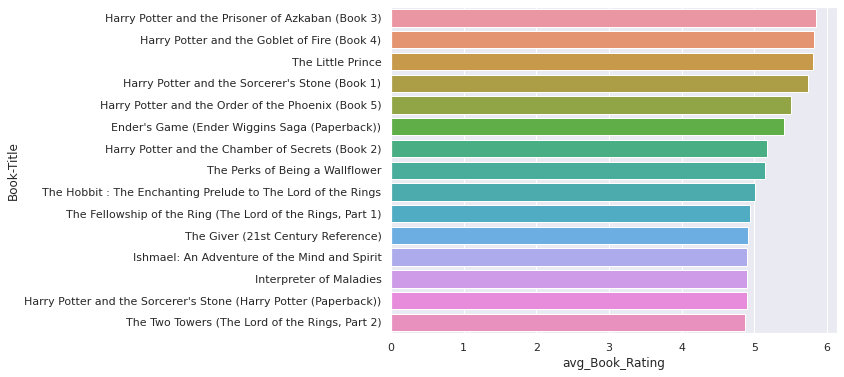

In [62]:
sns.barplot(y='Book-Title',x='avg_Book_Rating',data=temp_df_books.sort_values('avg_Book_Rating',ascending=False).head(15))

In [63]:
temp_df_author=df.groupby('Book-Author').agg({'Book-Rating':'mean','Book-Author':'count'}).rename(columns={'Book-Author':'count','Book-Rating':'avg_Book_Rating'}).reset_index()

In [64]:
temp_df_author=temp_df_author[temp_df_author['count']>100]
temp_df_author

,Book-Author,avg_Book_Rating,count
59,A. A. Milne,3.956835,139
247,A. Manette Ansay,2.290954,409
420,A.S. BYATT,2.453988,163
454,ADRIANA TRIGIANI,2.304000,125
471,ALBERT CAMUS,3.557143,140
...,...,...,...
100861,Wolfgang Hohlbein,3.551136,176
101077,Yann Martel,4.038571,700
101332,Zadie Smith,3.031532,222
101409,Zilpha Keatley Snyder,3.198276,116


In [65]:
temp_df_author.sort_values('avg_Book_Rating',ascending=False).head(15)

,Book-Author,avg_Book_Rating,count
16490,Clamp,6.513333,150
88879,Shel Silverstein,6.105820,189
9642,Bill Watterson,5.561818,550
5680,Antoine de Saint-ExupÃ©ry,5.553957,278
38028,Herge,5.519737,152
10439,Bradley Trevor Greive,5.431655,139
40389,J. K. Rowling,5.385832,2908
72430,Nick Bantock,5.292593,270
40548,J. R. R. Tolkien,5.165644,978
24644,Dr. Seuss,5.121294,371


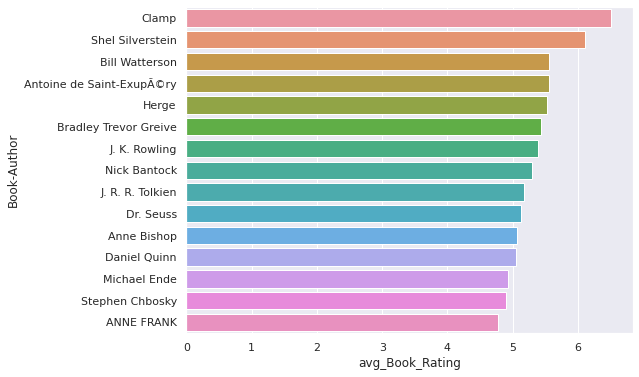

In [66]:
sns.barplot(y='Book-Author',x='avg_Book_Rating',data=temp_df_author.sort_values('avg_Book_Rating',ascending=False).head(15))

# data prep

In [67]:
combine_book_rating = pd.merge(ratings_df, books_df, on='ISBN')

combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books


In [68]:
book_rating=combine_book_rating.groupby('Book-Title') \
       .agg({'Book-Title':'count', 'Book-Rating':'mean'}) \
       .rename(columns={'Book-Title':'No_of_rating','Book-Rating':'AvgRatingCount'}) \
       .reset_index()
book_rating_temp=combine_book_rating.groupby('Book-Title') \
       .agg({ 'Book-Rating':'sum'}) \
       .rename(columns={'Book-Rating':'totalRatingCount'}) \
       .reset_index()

In [69]:
book_rating=pd.merge(book_rating_temp, book_rating, on='Book-Title', how='inner')

In [70]:
book_rating.sort_values(["totalRatingCount"], ascending=[False])

,Book-Title,totalRatingCount,No_of_rating,AvgRatingCount
196326,The Lovely Bones: A Novel,5787,1295,4.468726
183573,The Da Vinci Code,4169,898,4.642539
206502,The Secret Life of Bees,3442,774,4.447028
204387,The Red Tent (Bestselling Backlist),3134,723,4.334716
199237,The Nanny Diaries: A Novel,2923,828,3.530193
...,...,...,...,...
148482,Regeneration: Telling Stories from Our Twenties,0,1,0.000000
54788,Dr. Zhivago,0,2,0.000000
148480,"Regeneration, Toronto's waterfront and the sus...",0,2,0.000000
54789,Dr.Fischer of Geneva,0,2,0.000000


* total rating would be a good measuremnt for popularity 

In [71]:
combine_book_rating = combine_book_rating.merge(book_rating, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
combine_book_rating.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,totalRatingCount,No_of_rating,AvgRatingCount
0,276725,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,176,60,2.933333
1,2313,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,176,60,2.933333
2,6543,034545104X,0,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,176,60,2.933333
3,8680,034545104X,5,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,176,60,2.933333
4,10314,034545104X,9,Flesh Tones: A Novel,M. J. Rose,2002.0,Ballantine Books,176,60,2.933333


In [72]:
popular_books = combine_book_rating[(combine_book_rating['totalRatingCount'] >=30) & (combine_book_rating['AvgRatingCount'] >=5)]
popular_books.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,totalRatingCount,No_of_rating,AvgRatingCount
1992,276788,043935806X,7,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic,1909,347,5.501441
1993,278356,043935806X,10,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic,1909,347,5.501441
1994,254,043935806X,0,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic,1909,347,5.501441
1995,2033,043935806X,9,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic,1909,347,5.501441
1996,4896,043935806X,0,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003.0,Scholastic,1909,347,5.501441


In [73]:
popular_books = popular_books.drop_duplicates(['User-ID', 'Book-Title'])

# **Implementing Nearest Neighbours**

We convert our table to a 2D matrix, and fill the missing values with zeros (since we will calculate distances between rating vectors). We then transform the values(ratings) of the matrix dataframe into a scipy sparse matrix for more efficient calculations.

Finding the Nearest Neighbors We use unsupervised algorithms with sklearn.neighbors. The algorithm we use to compute the nearest neighbors is “auto”, and we specify “metric=minkowski”. Finally, we fit the model.

In [74]:
from scipy.sparse import csr_matrix
popular_books_rating_pivot = popular_books.pivot(index = 'Book-Title',columns = 'User-ID', values = 'AvgRatingCount').fillna(0)
popular_books_rating_matrix = csr_matrix(popular_books_rating_pivot.values)
popular_books_rating_pivot



User-ID,9,83,92,99,133,242,254,337,361,372,383,384,408,486,503,507,547,567,596,625,628,638,643,650,651,685,712,717,728,776,777,805,818,834,843,850,882,901,914,973,...,277744,277776,277812,277833,277873,277901,277908,277915,277945,277965,277982,278089,278137,278197,278218,278221,278238,278257,278279,278302,278355,278356,278361,278398,278418,278435,278439,278491,278535,278552,278563,278582,278597,278633,278637,278641,278650,278694,278720,278771
Book-Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"Earth Prayers From around the World: 365 Prayers, Poems, and Invocations for Honoring the Earth",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
!Yo!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
".Hack: //Legend of the Twilight, Vol. 1",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
".Hack: //Legend of the Twilight, Vol. 2",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"1,911 Best Things Anybody Ever Said",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zwei alte Frauen. Eine Legende von Verrat und Tapferkeit.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zweimal ist einmal zuviel.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"\B\"" is for burglar (A Kinsey Millhone mystery)""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [75]:
# Finding the Nearest Neighbors
from sklearn.neighbors import NearestNeighbors
#creating instance of NN
model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
#Fitting the data to model
model_knn.fit(popular_books_rating_matrix)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [76]:
# frinding random books index from the table
query_index = np.random.choice(popular_books_rating_pivot.shape[0])
print(query_index)

128


In [77]:
# randome book index value
popular_books_rating_pivot.index[query_index]

"Alice's Adventures in Wonderland and Through the Looking Glass (Bantam Classics)"

In [78]:
# finding the distance and books indices wich are nearest to thee given book 
distances, indices = model_knn.kneighbors(popular_books_rating_pivot.iloc[query_index,:].values.reshape(1, -1), n_neighbors = 6)

In [79]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for {0}:\n'.format(popular_books_rating_pivot.index[query_index]))
    else:
        print('{0}: {1}, with distance of {2}:'.format(i, popular_books_rating_pivot.index[indices.flatten()[i]], distances.flatten()[i]))

Recommendations for Alice's Adventures in Wonderland and Through the Looking Glass (Bantam Classics):

1: Everyone Dies: A Kevin Kerney Novel (Kevin Kerney Novels (Hardcover)), with distance of 0.8845299461620748:
2: In the Absence of the Sacred: The Failure of Technology and the Survival of the Indian Nations, with distance of 0.8845299461620748:
3: Chosen -2, with distance of 0.894590744661054:
4: Winesburg, Ohio (20th Century Classics), with distance of 0.894590744661054:
5: El Tunel, with distance of 0.9087129070824723:


# content based filtering

In [80]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [81]:
# combning all the data frames
df = pd.merge(books_df, ratings_df, on='ISBN', how='inner')
df = pd.merge(df, users_df, on='User-ID', how='inner')
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,2,0,"stockton, california, usa",18.000000
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,8,5,"timmins, ontario, canada",34.746638
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,8,0,"timmins, ontario, canada",34.746638
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,8,0,"timmins, ontario, canada",34.746638
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",34.746638


In [82]:
#Trains a model whose vectors composed by the main unigrams and bigrams found in the corpus, ignoring stopwords
vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 2),
                              min_df=0.001,max_df=0.95,
                              stop_words='english')

tfidf_matrix = vectorizer.fit_transform(books_df['Book-Title'] + " " + books_df['Book-Author'] + " " + books_df['Publisher'])
tfidf_feature_names = vectorizer.get_feature_names()
tfidf_matrix

<271360x1513 sparse matrix of type '<class 'numpy.float64'>'
	with 1452186 stored elements in Compressed Sparse Row format>

In [83]:
item_ids=books_df['ISBN'].to_list()

In [84]:
df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.0,Oxford University Press,2,0,"stockton, california, usa",18.000000
1,0002005018,Clara Callan,Richard Bruce Wright,2001.0,HarperFlamingo Canada,8,5,"timmins, ontario, canada",34.746638
2,0060973129,Decision in Normandy,Carlo D'Este,1991.0,HarperPerennial,8,0,"timmins, ontario, canada",34.746638
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.0,Farrar Straus Giroux,8,0,"timmins, ontario, canada",34.746638
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.0,W. W. Norton &amp; Company,8,0,"timmins, ontario, canada",34.746638


In [85]:
book_user_df=df.groupby(['User-ID','Book-Title','ISBN']).agg({ 'Book-Rating':'mean'}).rename(columns={'Book-Rating':'Total_Rating_Mean'}).reset_index()
user_count=book_user_df.groupby('User-ID').agg({'User-ID':'count'}).rename(columns={'User-ID':'count'}).reset_index()

In [86]:
book_user_df

,User-ID,Book-Title,ISBN,Total_Rating_Mean
0,2,Classical Mythology,0195153448,0
1,8,A Second Chicken Soup for the Woman's Soul (Ch...,1558746218,0
2,8,Clara Callan,0002005018,5
3,8,Decision in Normandy,0060973129,0
4,8,Flu: The Story of the Great Influenza Pandemic...,0374157065,0
...,...,...,...,...
1031131,278854,Hornet's Nest,042516098X,7
1031132,278854,In Her Day,0553275739,6
1031133,278854,Kat Scratch Fever (Kat Colorado Mysteries),0425163393,7
1031134,278854,The Cat Who Ate Danish Modern (Cat Who... (Pap...,0515087122,0


In [87]:
# selecting those users who have at least read 10 books
user_count=user_count[user_count['count']>10]

In [88]:
user_count

,User-ID,count
1,8,17
42,99,12
82,242,28
83,243,79
87,254,300
...,...,...
92027,278633,73
92030,278637,16
92070,278771,11
92099,278843,60


In [89]:
# reemoving excess users
book_user_df=pd.merge(book_user_df,user_count,on='User-ID',how='inner')
book_user_df

,User-ID,Book-Title,ISBN,Total_Rating_Mean,count
0,8,A Second Chicken Soup for the Woman's Soul (Ch...,1558746218,0,17
1,8,Clara Callan,0002005018,5,17
2,8,Decision in Normandy,0060973129,0,17
3,8,Flu: The Story of the Great Influenza Pandemic...,0374157065,0,17
4,8,Goodbye to the Buttermilk Sky,1881320189,7,17
...,...,...,...,...,...
859888,278851,The Bachelor Home Companion: A Practical Guide...,067161746X,7,23
859889,278851,The Military Quotation Book : Revised and Expa...,0312266448,0,23
859890,278851,"Then Again, Maybe I Won't",0440486599,5,23
859891,278851,WebClasses From Scratch,0789721260,5,23


In [90]:
# removing the users which read only zero rating books
zero_df=book_user_df.groupby('User-ID')['Total_Rating_Mean'].sum().reset_index()
zero_rating_list=list(zero_df[zero_df['Total_Rating_Mean']==0]['User-ID'])
book_user_df = book_user_df[~book_user_df['User-ID'].isin(zero_rating_list)]


In [91]:
combined = book_user_df.merge(users_df, on = 'User-ID', how = 'inner')

# using only usa bases users for better modeling speed
us_user_rating = combined[combined['Location'].str.contains("usa")]
us_user_rating=us_user_rating.drop('Age', axis=1)
us_user_rating

,User-ID,Book-Title,ISBN,Total_Rating_Mean,count,Location
17,99,Corelli's Mandolin : A Novel,067976397X,0,12,"franktown, colorado, usa"
18,99,Creating Wealth : Retire in Ten Years Using Al...,0671621009,10,12,"franktown, colorado, usa"
19,99,Fast Women,0312252617,8,12,"franktown, colorado, usa"
20,99,Female Intelligence,0312261594,8,12,"franktown, colorado, usa"
21,99,"Love, Miracles, and Animal Healing : A heartwa...",0684822733,0,12,"franktown, colorado, usa"
...,...,...,...,...,...,...
848176,278851,The Bachelor Home Companion: A Practical Guide...,067161746X,7,23,"dallas, texas, usa"
848177,278851,The Military Quotation Book : Revised and Expa...,0312266448,0,23,"dallas, texas, usa"
848178,278851,"Then Again, Maybe I Won't",0440486599,5,23,"dallas, texas, usa"
848179,278851,WebClasses From Scratch,0789721260,5,23,"dallas, texas, usa"


In [92]:

def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = tfidf_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

def build_users_profile(person_id, interactions_indexed_df):
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['ISBN'])
    
    user_item_strengths = np.array(interactions_person_df['Total_Rating_Mean']).reshape(-1,1)
    
    # Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_profile_norm = normalize(user_item_strengths_weighted_avg)
    return user_profile_norm

def build_users_profiles(): 
    interactions_indexed_df = us_user_rating[us_user_rating['ISBN'].isin(books_df['ISBN'])].set_index('User-ID')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    return user_profiles

In [93]:
us_user_rating[us_user_rating['ISBN'].isin(books_df['ISBN'])].set_index('User-ID')

,Book-Title,ISBN,Total_Rating_Mean,count,Location
User-ID,,,,,
99,Corelli's Mandolin : A Novel,067976397X,0,12,"franktown, colorado, usa"
99,Creating Wealth : Retire in Ten Years Using Al...,0671621009,10,12,"franktown, colorado, usa"
99,Fast Women,0312252617,8,12,"franktown, colorado, usa"
99,Female Intelligence,0312261594,8,12,"franktown, colorado, usa"
99,"Love, Miracles, and Animal Healing : A heartwa...",0684822733,0,12,"franktown, colorado, usa"
...,...,...,...,...,...
278851,The Bachelor Home Companion: A Practical Guide...,067161746X,7,23,"dallas, texas, usa"
278851,The Military Quotation Book : Revised and Expa...,0312266448,0,23,"dallas, texas, usa"
278851,"Then Again, Maybe I Won't",0440486599,5,23,"dallas, texas, usa"


In [94]:
user_profiles = build_users_profiles()

In [95]:
from sklearn.model_selection import train_test_split

In [96]:
book_user_train_df, book_user_test_df = train_test_split(us_user_rating.drop('count',axis=1),
                                                          stratify=us_user_rating['User-ID'], 
                                                          test_size=0.20,
                                                          random_state=42)

In [97]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, person_id, topn=1000):
        
        # Compute the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[person_id], tfidf_matrix)
        
        # Get the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        
        # Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['ISBN', 'recStrength']).head(topn)


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(books_df)

## Evaluation

In [98]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = book_user_df.set_index('User-ID')
interactions_train_indexed_df = book_user_train_df.set_index('User-ID')
interactions_test_indexed_df = book_user_test_df.set_index('User-ID')

In [99]:
def get_items_interacted(UserID, interactions_df):
    interacted_items = interactions_df.loc[UserID]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [100]:
import random

In [101]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(books_df['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([str(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        hits_at_15_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id)    #%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            hit_at_15, index_at_15 = self._verify_hit_top_n(item_id, valid_recs, 15)
            hits_at_15_count += hit_at_15

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        recall_at_15 = hits_at_15_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@15_count':hits_at_15_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@15': recall_at_15}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['User-ID'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_15 = detailed_results_df['hits@15_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'recall@15': global_recall_at_15}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [102]:
print('Evaluating Content-Based Filtering model...')
cb_global_metrics, cb_detailed_results_df = model_evaluator.evaluate_model(content_based_recommender_model)


Evaluating Content-Based Filtering model...
7093 users processed


In [103]:
user_profiles[195100]

array([[0., 0., 0., ..., 0., 0., 0.]])

In [104]:
user_profiles.keys()

dict_keys([99, 243, 254, 383, 388, 408, 424, 446, 487, 503, 505, 507, 638, 651, 709, 728, 735, 741, 753, 805, 882, 900, 1075, 1129, 1155, 1167, 1184, 1248, 1435, 1485, 1548, 1585, 1608, 1674, 1733, 1812, 1848, 1928, 2010, 2024, 2030, 2033, 2041, 2046, 2090, 2103, 2110, 2132, 2134, 2179, 2276, 2287, 2288, 2313, 2337, 2358, 2363, 2437, 2589, 2630, 2719, 2766, 2790, 2793, 2799, 2853, 2855, 2891, 2954, 2977, 3145, 3167, 3329, 3331, 3363, 3371, 3373, 3481, 3542, 3556, 3640, 3643, 3693, 3719, 3817, 3827, 3840, 4017, 4091, 4092, 4157, 4197, 4221, 4228, 4385, 4401, 4570, 4600, 4622, 4785, 4795, 4938, 5037, 5207, 5209, 5385, 5439, 5448, 5452, 5490, 5539, 5543, 5582, 5638, 5669, 5728, 5741, 5815, 5956, 5963, 6051, 6073, 6102, 6115, 6120, 6156, 6251, 6323, 6333, 6345, 6431, 6543, 6563, 6566, 6575, 6577, 6582, 6604, 6671, 6700, 6731, 6769, 6781, 6789, 6865, 6871, 6894, 6900, 6958, 7060, 7082, 7125, 7128, 7134, 7158, 7283, 7286, 7312, 7318, 7341, 7346, 7352, 7426, 7528, 7569, 7620, 7630, 7809, 7841

In [105]:
print('\nGlobal metrics:\n%s' % cb_global_metrics)
cb_detailed_results_df.head(10)


Global metrics:
{'modelName': 'Content-Based', 'recall@5': 0.11525642147465218, 'recall@10': 0.11525642147465218, 'recall@15': 0.11525642147465218}


,hits@5_count,hits@10_count,hits@15_count,interacted_count,recall@5,recall@10,recall@15,User-ID
134,4,4,4,1291,0.003098,0.003098,0.003098,198711
50,11,11,11,1163,0.009458,0.009458,0.009458,153662
0,62,62,62,1156,0.053633,0.053633,0.053633,98391
187,59,59,59,1129,0.052259,0.052259,0.052259,35859
204,2,2,2,799,0.002503,0.002503,0.002503,278418
125,3,3,3,666,0.004505,0.004505,0.004505,76352
18,14,14,14,594,0.023569,0.023569,0.023569,110973
195,20,20,20,589,0.033956,0.033956,0.033956,235105
173,4,4,4,584,0.006849,0.006849,0.006849,16795
229,7,7,7,572,0.012238,0.012238,0.012238,230522


# **Collaborative Filtering**

Collaborative filtering (CF) is a technique used by recommender systems.In the newer, narrower sense, collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating).

In [106]:
#viewing top 5 row of user Data
users_df.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",34.746638
1,2,"stockton, california, usa",18.000000
2,3,"moscow, yukon territory, russia",34.746638
3,4,"porto, v.n.gaia, portugal",17.000000
4,5,"farnborough, hants, united kingdom",34.746638


## **Collaborative Filtering Using k-Nearest Neighbors (kNN)**

kNN is a machine learning algorithm to find clusters of similar users based on common book ratings, and make predictions using the average rating of top-k nearest neighbors. For example, we first present ratings in a matrix with the matrix having one row for each item (book) and one column for each user.

First, we need to find out the average rating, and the number of ratings each book received.

In [107]:
#creating Dataframe to find the average rating of each book grouping by ISBN number
average_rating = pd.DataFrame(ratings_df.groupby('ISBN')['Book-Rating'].mean())
average_rating['ratingCount'] = pd.DataFrame(ratings_df.groupby('ISBN')['Book-Rating'].count())
average_rating.sort_values('ratingCount', ascending=False)

,Book-Rating,ratingCount
ISBN,,
0971880107,1.019584,2502
0316666343,4.468726,1295
0385504209,4.652322,883
0060928336,3.448087,732
0312195516,4.334716,723
...,...,...
0801064090,0.000000,1
0801064252,5.000000,1
0801064279,0.000000,1


observation
* In this data set, the book that received most rating counts was not highly rated at all. As a result, if we were to use recommendations based on rating counts, we would definitely make mistakes here. So, we need to have a better system.

##**Note**
**To ensure statistical significance, We will consider only those books in which atleast 50 ratings have been given by the users and users who have given atleast 50 ratings**

In [108]:
counts = ratings_df['Book-Rating'].value_counts()
ratings_df = ratings_df[ratings_df['Book-Rating'].isin(counts[counts >= 50].index)]
counts1 = ratings_df['User-ID'].value_counts()
ratings_df = ratings_df[ratings_df['User-ID'].isin(counts1[counts1 >= 50].index)]


Merging the two dataset (ratings data and books data.)

In [109]:
#merging both DF on ISBN number
combine_book_rating = pd.merge(ratings_df, books_df, on='ISBN')
#columns = ['Year-Of-Publication', 'Publisher', 'Book-Author', 'Image-URL-S', 'Image-URL-M', 'Image-URL-L']
#droping extra columns
#combine_book_rating = combine_book_rating.drop(columns, axis=1)
#viewing top 20 row of merged DF
combine_book_rating.head(20)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
5,9177,0446364193,7,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
6,11400,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
7,11676,0446364193,8,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
8,14521,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books
9,15418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books


In [110]:
#droping columns where Book title is Null
combine_book_rating = combine_book_rating.dropna(axis = 0, subset = ['Book-Title'])

We then group by book titles and create a new column for total rating count.

In [111]:
book_ratingCount = (combine_book_rating.
     groupby(by = ['Book-Title'])['Book-Rating'].
     count().
     reset_index().
     rename(columns = {'Book-Rating': 'TotalRatingCount'})
     [['Book-Title', 'TotalRatingCount']]
    )
book_ratingCount.head()

,Book-Title,TotalRatingCount
0,A Light in the Storm: The Civil War Diary of ...,4
1,Always Have Popsicles,1
2,Apple Magic (The Collector's series),1
3,"Ask Lily (Young Women of Faith: Lily Series, ...",1
4,Beyond IBM: Leadership Marketing and Finance ...,1


Combine the rating data with the total rating count data, this gives us exactly what we need to find out which books are popular and filter out lesser-known books.

In [112]:
rating_with_totalRatingCount = combine_book_rating.merge(book_ratingCount, left_on = 'Book-Title', right_on = 'Book-Title', how = 'left')
rating_with_totalRatingCount.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,TotalRatingCount
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books,198
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books,198
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books,198
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books,198
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.0,Warner Books,198


In [113]:
#describing the new data
rating_with_totalRatingCount['TotalRatingCount'].describe()

count    703434.000000
mean         35.008956
std          68.959965
min           1.000000
25%           2.000000
50%           8.000000
75%          34.000000
max         852.000000
Name: TotalRatingCount, dtype: float64

In [114]:
# Converting the values into float data type.
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# It provides the descriptive statistcs of the data.
print(book_ratingCount['TotalRatingCount'].describe())

count   199187.00
mean         3.53
std         10.54
min          1.00
25%          1.00
50%          1.00
75%          3.00
max        852.00
Name: TotalRatingCount, dtype: float64


observation
* The median book has been rated only once. 

Let’s look at from 90% to 99% to identify the TotalRatingCounts for each of the quantile.

In [115]:
print(book_ratingCount['TotalRatingCount'].quantile(np.arange(.9, 1, .01)))

0.90    6.00
0.91    7.00
0.92    7.00
0.93    8.00
0.94    9.00
0.95   11.00
0.96   13.00
0.97   17.00
0.98   23.00
0.99   39.00
Name: TotalRatingCount, dtype: float64


observation
* We can see about 99% of books received below 31 ratings.
* Only about 1% of books recieved 31 or more ratings.

As we have so many books in our data, we will limit to above 30 ratings only.

In [116]:
# Limiting TotalRatingCount above 30 ratings.
popularity_threshold = 30
rating_popular_book = rating_with_totalRatingCount.query('TotalRatingCount >= @popularity_threshold')
rating_popular_book.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,TotalRatingCount
0,276847,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198
2,5483,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198


In [117]:
# Checking the total size of rating_popular_book.
rating_popular_book.shape

(192670, 8)

Check the number of unique books with respect to the ISBN

In [118]:
rating_popular_book['ISBN'].nunique()

7653

# **Filter to users in US**

In order to improve computing speed, and not run into the 'MemoryError' issue we will limit our users data to those in the US. Then combine the user data with rating data and total rating count data.

In [119]:
combined = rating_popular_book.merge(users_df, left_on = 'User-ID', right_on = 'User-ID', how = 'left')

us_user_rating = combined[combined['Location'].str.contains("usa")]
us_user_rating=us_user_rating.drop('Age', axis=1)
us_user_rating

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,TotalRatingCount,Location
1,278418,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198,"omaha, nebraska, usa"
3,7346,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198,"sunnyvale, california, usa"
4,8362,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198,"los angeles, california, usa"
8,14521,0446364193,0,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198,"providence, rhode island, usa"
10,16795,0446364193,8,Along Came a Spider (Alex Cross Novels),James Patterson,1993.00,Warner Books,198,"mechanicsville, maryland, usa"
...,...,...,...,...,...,...,...,...,...
192665,275970,051756338X,0,Sarum: The Novel of England,Edward Rutherfurd,1987.00,Random House Inc,45,"pittsburgh, pennsylvania, usa"
192666,275970,0865714215,0,Stormy Weather,Guy Dauncey,2001.00,New Society Publishers,59,"pittsburgh, pennsylvania, usa"
192667,275970,1586210661,9,Me Talk Pretty One Day,David Sedaris,2001.00,Time Warner Audio Major,257,"pittsburgh, pennsylvania, usa"
192668,276688,0517145553,0,Mostly Harmless,Douglas Adams,1995.00,Random House Value Pub,30,"fort lee, new jersey, usa"


Remove the duplicates present in rating popular book data.

In [120]:
if not rating_popular_book[rating_popular_book.duplicated(['User-ID', 'Book-Title'])].empty:

    # Identifying number of rows corresponding to the US.
    print('Actual rating_popular_book shape {0}'.format(rating_popular_book.shape))

    rating_popular_book = rating_popular_book.drop_duplicates(['User-ID', 'Book-Title'])

    # Identifying number of rows corresponding to the US duplicates.
    print('Rating_popular_book shape after removing the duplicates  {0}'.format(rating_popular_book.shape))

Actual rating_popular_book shape (192670, 8)
Rating_popular_book shape after removing the duplicates  (189333, 8)


# **Filtering users with atleast 10 interaction**

In [121]:
users_interactions_count_df = us_user_rating.groupby(['ISBN', 'User-ID']).size().groupby('User-ID').size()
print('Number of users: %d' % len(users_interactions_count_df))

users_with_enough_interactions_df = users_interactions_count_df[users_interactions_count_df >= 10].reset_index()[['User-ID']]
print('Number of users with at least 10 interactions: %d' % len(users_with_enough_interactions_df))

Number of users: 2116
Number of users with at least 10 interactions: 1960


In [122]:
print('Number of interactions: %d' % len(us_user_rating))
interactions_from_selected_users_df = us_user_rating.merge(users_with_enough_interactions_df, 
               how = 'right',
               left_on = 'User-ID',
               right_on = 'User-ID')
print('Number of interactions from users with at least 10 interactions: %d' % len(interactions_from_selected_users_df))

Number of interactions: 151815
Number of interactions from users with at least 10 interactions: 150986


In [123]:
interactions_from_selected_users_df.head(10)

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Publisher,TotalRatingCount,Location
0,243,0316666343,0,The Lovely Bones: A Novel,Alice Sebold,2002.00,"Little, Brown",577,"arden hills, minnesota, usa"
1,243,0679450408,0,Silent Witness,Richard North Patterson,1997.00,Random House Inc,99,"arden hills, minnesota, usa"
2,243,0743486226,0,Angels &amp; Demons,Dan Brown,2003.00,Atria,348,"arden hills, minnesota, usa"
3,243,042511774X,0,Breathing Lessons,Anne Tyler,1994.00,Berkley Publishing Group,155,"arden hills, minnesota, usa"
4,243,0446605484,0,Roses Are Red (Alex Cross Novels),James Patterson,2001.00,Warner Vision,137,"arden hills, minnesota, usa"
5,243,0446606383,6,The Midnight Club,James Patterson,1999.00,Warner Vision,73,"arden hills, minnesota, usa"
6,243,0316096199,0,Lucky : A Memoir,Alice Sebold,2002.00,Back Bay Books,194,"arden hills, minnesota, usa"
7,243,0316776963,9,Me Talk Pretty One Day,David Sedaris,2001.00,Back Bay Books,257,"arden hills, minnesota, usa"
8,243,0345311396,0,Private Screening,Richard North Patterson,1994.00,Ballantine Books,48,"arden hills, minnesota, usa"
9,243,0380718332,0,All That Remains (Kay Scarpetta Mysteries (Pap...,Patricia D. Cornwell,1993.00,Avon,130,"arden hills, minnesota, usa"


## **We are applying log transformation to smooth the distribution!!**

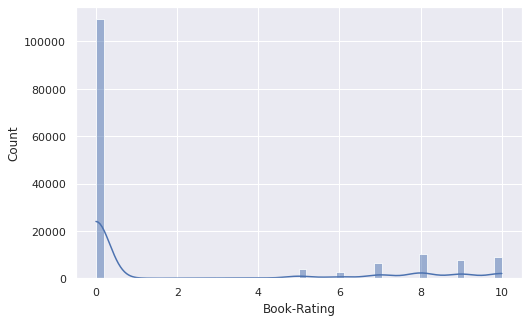

In [124]:
# Before log transformation
plt.figure(figsize=(8, 5))
sns.histplot(interactions_from_selected_users_df.groupby(['ISBN', 'User-ID'])['Book-Rating'].sum(), kde=True)
plt.show()

In [125]:
import math
def smooth_user_preference(x):
    return math.log(1+x, 2)
    
interactions_full_df = interactions_from_selected_users_df.groupby(['ISBN', 'User-ID'])['Book-Rating'].sum().apply(smooth_user_preference).reset_index()
print('Number of unique user/item interactions: %d' % len(interactions_full_df))
interactions_full_df.head()

Number of unique user/item interactions: 150986


,ISBN,User-ID,Book-Rating
0,000649840X,100459,0.00
1,000649840X,168816,0.00
2,000649840X,194669,0.00
3,000649840X,221445,0.00
4,000651202x,114988,0.00


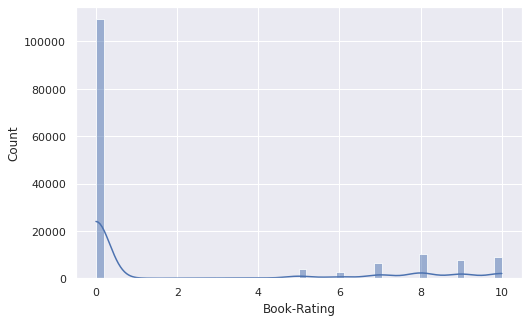

In [126]:
# After log transformation
plt.figure(figsize=(8, 5))
sns.histplot(interactions_from_selected_users_df.groupby(['ISBN', 'User-ID'])['Book-Rating'].sum(), kde=True)
plt.show()

# **Splitting data into Train And Test Dataset**

In [127]:
from sklearn.model_selection import train_test_split

interactions_train_df, interactions_test_df = train_test_split(interactions_full_df,
                                   stratify=interactions_full_df['User-ID'], 
                                   test_size=0.20,
                                   random_state=42)

print('Number interactions on Train set: %d' % len(interactions_train_df))
print('Number interactions on Test set: %d' % len(interactions_test_df))

Number interactions on Train set: 120788
Number interactions on Test set: 30198


In [128]:
interactions_test_df.head()

,ISBN,User-ID,Book-Rating
45011,0385335490,266650,0.00
124008,0671568833,254465,0.00
5083,0060987561,145641,0.00
24313,0345339738,164728,3.32
121366,0671027387,219546,0.00


In [129]:
#Creating a sparse pivot table with users in rows and items in columns
users_items_pivot_matrix_df = interactions_train_df.pivot(index='User-ID', 
                                                          columns='ISBN', 
                                                          values='Book-Rating').fillna(0)

users_items_pivot_matrix_df.head()

ISBN,000649840X,000651202x,0007110928,0020198906,002026478X,0020412401,0020442203,0020442408,0020442505,0020442602,0020811853,002542730X,002542730x,0027587800,0027701301,0028604199,0028604202,0030615534,0060001453,0060001941,006000438X,0060008024,0060008032,0060008245,0060008296,0060008776,0060009241,0060011173,006001203X,0060013117,0060013125,0060080841,006008216X,0060083948,0060085444,0060085452,0060086246,0060086386,0060089539,0060090367,...,185326041X,1853260916,1853262390,1853268496,1858912164,1860462588,1860492592,1865083348,1878424319,1878448900,1878702831,1882723007,1885171080,188517120X,1885628501,1886028486,1895565669,1896095011,1896860982,1898901147,1931056323,193156146X,1931561648,1932234039,2020053667,225317114X,3895084573,555053150X,5551154718,5552034341,5557121005,9501513092,B00006I4OX,B000078UH8,B00007CWQC,B00009ANY9,B00009EF82,B0000T6KHI,B0000VZEH8,B0001GMSV2
User-ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
243,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
254,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
507,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
638,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
741,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [130]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [131]:
# Check the list of user id of the users
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

[243, 254, 507, 638, 741, 882, 1435, 1674, 1733, 1848]

# **SVD - Model Based Collaborative Filtering**

The Singular-Value Decomposition, or SVD for short, is a matrix decomposition method for reducing a matrix to its constituent parts in order to make certain subsequent matrix calculations simpler. It provides another way to factorize a matrix, into singular vectors and singular values.

# **A=U.Sigma.VT**

In [152]:
#importing cosine_similarity
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

In [153]:
# The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix
U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)

In [ ]:
users_items_pivot_matrix.shape

In [154]:
U.shape

(1960, 15)

In [155]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [156]:
Vt.shape

(15, 6739)

**After the factorization, we try to to reconstruct the original matrix by multiplying its factors. The resulting matrix is not sparse any more. It was generated predictions for items the user have not yet interaction, which we will exploit for recommendations.**

In [157]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.39550415e-02,  0.00000000e+00, -8.22360391e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.28464917e-03,  0.00000000e+00,  3.66593547e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         9.36896198e-05,  0.00000000e+00, -2.73125691e-04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -2.75381224e-02,  0.00000000e+00, -1.18308869e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         4.70848032e-02,  0.00000000e+00, -5.20139190e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.51632883e-03,  0.00000000e+00,  5.07391362e-04]])

In [158]:
all_user_predicted_ratings.shape

(1960, 6739)

**Making DataFrame from our predicted ratings.**

In [159]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head()

,243,254,507,638,741,882,1435,1674,1733,1848,2033,2110,2276,2358,2766,2891,2977,3145,3167,3363,3371,3373,3556,3827,4017,4092,4157,4385,4622,4785,4938,5439,5539,5582,6073,6251,6323,6431,6543,6563,...,272077,272120,272573,272626,273086,273113,273979,274056,274061,274308,274466,274549,274634,274656,274808,275020,275276,275281,275922,275970,276050,276165,276231,276463,276680,276688,277157,277195,277427,277639,277928,277965,278026,278137,278144,278188,278418,278582,278633,278843
ISBN,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000649840X,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
000651202x,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0007110928,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
0020198906,0.02,0.00,0.01,-0.00,-0.00,-0.01,0.01,-0.00,-0.01,0.00,0.01,-0.00,0.02,-0.00,0.00,0.01,0.01,0.01,0.01,0.01,0.00,0.00,-0.02,0.01,0.02,-0.00,0.00,0.01,0.00,-0.00,0.00,0.01,0.00,0.00,0.01,0.06,0.01,0.01,0.04,0.05,...,-0.00,0.00,0.03,-0.00,0.01,-0.02,0.02,0.01,-0.05,0.01,0.01,0.01,-0.01,0.00,0.01,-0.00,0.00,-0.00,0.00,0.02,0.03,-0.01,0.03,0.00,-0.01,0.00,-0.00,0.00,0.04,0.02,0.00,0.00,0.02,0.00,-0.00,0.01,0.00,0.02,-0.01,0.00
002026478X,-0.02,0.01,-0.01,-0.02,-0.00,-0.03,-0.01,-0.00,-0.01,-0.02,0.01,0.01,-0.02,-0.00,0.04,0.00,0.01,-0.01,0.07,0.03,0.04,-0.02,-0.02,-0.00,0.06,-0.01,0.02,-0.00,0.02,-0.01,0.04,-0.02,0.01,-0.00,0.02,0.05,0.00,-0.01,-0.01,-0.03,...,0.01,-0.00,0.04,0.00,0.02,-0.03,0.01,0.05,0.02,-0.01,0.00,0.01,-0.00,-0.00,0.01,-0.00,-0.00,-0.01,-0.02,-0.01,0.03,-0.05,0.04,-0.00,-0.02,0.00,-0.00,-0.00,0.04,-0.02,-0.00,-0.00,0.02,0.02,0.00,0.01,0.02,-0.02,0.02,-0.00


In [160]:
len(cf_preds_df.columns)

1960

In [161]:
global books_df
books_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,0195153448,Classical Mythology,Mark P. O. Morford,2002.00,Oxford University Press
1,0002005018,Clara Callan,Richard Bruce Wright,2001.00,HarperFlamingo Canada
2,0060973129,Decision in Normandy,Carlo D'Este,1991.00,HarperPerennial
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999.00,Farrar Straus Giroux
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999.00,W. W. Norton &amp; Company


### **Colaborative Filtering Recommender Class**

In [162]:
import random

In [163]:
# creating class for collaborative Filtering
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df):
        self.cf_predictions_df = cf_predictions_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False).reset_index().rename(columns={user_id: 'recStrength'})

        # Recommend the highest predicted rating content that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['ISBN'].isin(items_to_ignore)].sort_values('recStrength', ascending = False).head(topn)
        recommendations_df=recommendations_df.merge(books_df,on='ISBN',how='inner')
        recommendations_df=recommendations_df[['ISBN','Book-Title','recStrength']]

        return recommendations_df



cf_recommender_model = CFRecommender(cf_preds_df)

# **Evaluation**

### In Recommender Systems, there are a set metrics commonly used for evaluation. We choose to work with **Top-N accuracy metrics**, which evaluates the accuracy of the top recommendations provided to a user, comparing to the items the user has actually interacted in test set.

### This evaluation method works as follows:

* ### For each user
    * ### For each item the user has interacted in test set
        * ### Sample 100 other items the user has never interacted.   
        * ### Ask the recommender model to produce a ranked list of recommended items, from a set composed of one interacted item and the 100 non-interacted items
        * ### Compute the Top-N accuracy metrics for this user and interacted item from the recommendations ranked list
* ### Aggregate the global Top-N accuracy metrics

In [145]:
#Indexing by personId to speed up the searches during evaluation
interactions_full_indexed_df = interactions_full_df.set_index('User-ID')
interactions_train_indexed_df = interactions_train_df.set_index('User-ID')
interactions_test_indexed_df = interactions_test_df.set_index('User-ID')

The Top-N accuracy metric choosen was **Recall@N** which evaluates whether the interacted item is among the top N items (hit) in the ranked list of 101 recommendations for a user.

In [146]:
def get_items_interacted(UserID, interactions_df):
    interacted_items = interactions_df.loc[UserID]['ISBN']
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

In [147]:
class ModelRecommender:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(us_user_rating['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([str(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)
        print('Recommendation for User-ID = ',person_id)
        print(person_recs_df.head(10))

        # Function to evaluate the performance of model at overall level
    def recommend_book(self, model ,userid):
        
        person_metrics = self.evaluate_model_for_user(model, userid)  
        return

model_recommender = ModelRecommender()

In [148]:
#printing the interaction's index no.
print(list(interactions_full_indexed_df.index.values))

[100459, 168816, 194669, 221445, 114988, 142524, 7346, 13273, 14422, 29259, 36836, 37019, 68984, 76352, 81045, 83637, 88733, 101876, 105979, 108352, 115490, 135831, 138010, 140036, 148744, 155147, 157273, 174304, 201684, 206959, 266056, 271195, 277965, 3145, 16488, 35857, 35859, 36606, 36836, 39441, 42914, 44728, 52584, 55492, 68156, 68943, 91832, 93629, 95359, 104113, 105979, 113519, 115490, 126726, 126736, 127429, 135149, 145619, 152249, 157273, 190741, 198711, 211426, 221445, 229741, 231210, 235105, 242106, 242361, 242824, 245963, 248718, 252695, 264947, 266056, 268622, 269566, 269719, 271448, 9856, 190708, 231827, 16634, 23768, 31040, 35050, 55492, 85656, 87555, 88733, 93363, 96448, 114414, 122429, 146175, 147847, 155027, 157127, 173291, 184465, 185384, 197687, 200422, 203240, 228998, 230522, 234623, 238545, 239584, 253106, 269566, 271705, 278418, 6251, 16634, 29259, 31040, 35050, 38023, 55492, 64241, 66878, 80234, 83287, 87555, 88733, 93363, 126736, 146175, 147847, 155027, 155495,

In [149]:
#taking user_id for Recommendation
#user=int(input("Enter User ID from above list for book recommendation:  "))
#lets take user input  =110934
user=110934 
model_recommender.recommend_book(cf_recommender_model,user)

Recommendation for User-ID =  110934
         ISBN                                         Book-Title  recStrength
0  043935806X  Harry Potter and the Order of the Phoenix (Boo...         3.23
1  0671001795                                  Two for the Dough         2.55
2  0590353403     Harry Potter and the Sorcerer's Stone (Book 1)         2.41
3  059035342X  Harry Potter and the Sorcerer's Stone (Harry P...         1.70
4  0312265867               To the Nines: A Stephanie Plum Novel         1.55
5  0671027360                                Angels &amp; Demons         1.32
6  0312983271         Full House (Janet Evanovich's Full Series)         1.12
7  0061009059  One for the Money (Stephanie Plum Novels (Pape...         1.10
8  0312195516                The Red Tent (Bestselling Backlist)         1.03
9  0385504209                                  The Da Vinci Code         1.00


In [150]:
#Top-N accuracy metrics consts
EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS = 100

class ModelEvaluator:

    # Function for getting the set of items which a user has not interacted with
    def get_not_interacted_items_sample(self, UserID, sample_size, seed=42):
        interacted_items = get_items_interacted(UserID, interactions_full_indexed_df)
        all_items = set(us_user_rating['ISBN'])
        non_interacted_items = all_items - interacted_items

        random.seed(seed)
        non_interacted_items_sample = random.sample(non_interacted_items, sample_size)
        return set(non_interacted_items_sample)

    # Function to verify whether a particular item_id was present in the set of top N recommended items
    def _verify_hit_top_n(self, item_id, recommended_items, topn):        
            try:
                index = next(i for i, c in enumerate(recommended_items) if c == item_id)
            except:
                index = -1
            hit = int(index in range(0, topn))
            return hit, index
    
    # Function to evaluate the performance of model for each user
    def evaluate_model_for_user(self, model, person_id):
        
        # Getting the items in test set
        interacted_values_testset = interactions_test_indexed_df.loc[person_id]
        
        if type(interacted_values_testset['ISBN']) == pd.Series:
            person_interacted_items_testset = set(interacted_values_testset['ISBN'])
        else:
            person_interacted_items_testset = set([str(interacted_values_testset['ISBN'])])
            
        interacted_items_count_testset = len(person_interacted_items_testset) 

        # Getting a ranked recommendation list from the model for a given user
        person_recs_df = model.recommend_items(person_id, items_to_ignore=get_items_interacted(person_id, interactions_train_indexed_df),topn=10000000000)

        hits_at_5_count = 0
        hits_at_10_count = 0
        hits_at_15_count = 0
        
        # For each item the user has interacted in test set
        for item_id in person_interacted_items_testset:
            
            # Getting a random sample of 100 items the user has not interacted with
            non_interacted_items_sample = self.get_not_interacted_items_sample(person_id, sample_size=EVAL_RANDOM_SAMPLE_NON_INTERACTED_ITEMS, seed=item_id)    #%(2**32))

            # Combining the current interacted item with the 100 random items
            items_to_filter_recs = non_interacted_items_sample.union(set([item_id]))

            # Filtering only recommendations that are either the interacted item or from a random sample of 100 non-interacted items
            valid_recs_df = person_recs_df[person_recs_df['ISBN'].isin(items_to_filter_recs)]                    
            valid_recs = valid_recs_df['ISBN'].values
            
            # Verifying if the current interacted item is among the Top-N recommended items
            hit_at_5, index_at_5 = self._verify_hit_top_n(item_id, valid_recs, 5)
            hits_at_5_count += hit_at_5
            hit_at_10, index_at_10 = self._verify_hit_top_n(item_id, valid_recs, 10)
            hits_at_10_count += hit_at_10
            hit_at_15, index_at_15 = self._verify_hit_top_n(item_id, valid_recs, 15)
            hits_at_15_count += hit_at_15

        # Recall is the rate of the interacted items that are ranked among the Top-N recommended items
        recall_at_5 = hits_at_5_count / float(interacted_items_count_testset)
        recall_at_10 = hits_at_10_count / float(interacted_items_count_testset)
        recall_at_15 = hits_at_15_count / float(interacted_items_count_testset)

        person_metrics = {'hits@5_count':hits_at_5_count, 
                          'hits@10_count':hits_at_10_count, 
                          'hits@15_count':hits_at_15_count,
                          'interacted_count': interacted_items_count_testset,
                          'recall@5': recall_at_5,
                          'recall@10': recall_at_10,
                          'recall@15': recall_at_15}
        return person_metrics

    
    # Function to evaluate the performance of model at overall level
    def evaluate_model(self, model):
        
        people_metrics = []
        
        for idx, person_id in enumerate(list(interactions_test_indexed_df.index.unique().values)):    
            person_metrics = self.evaluate_model_for_user(model, person_id)  
            person_metrics['User-ID'] = person_id
            people_metrics.append(person_metrics)
            
        print('%d users processed' % idx)

        detailed_results_df = pd.DataFrame(people_metrics).sort_values('interacted_count', ascending=False)
        
        global_recall_at_5 = detailed_results_df['hits@5_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_10 = detailed_results_df['hits@10_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        global_recall_at_15 = detailed_results_df['hits@15_count'].sum() / float(detailed_results_df['interacted_count'].sum())
        
        global_metrics = {'modelName': model.get_model_name(),
                          'recall@5': global_recall_at_5,
                          'recall@10': global_recall_at_10,
                          'recall@15': global_recall_at_15}    
        return global_metrics, detailed_results_df
    
model_evaluator = ModelEvaluator()

In [164]:
print('Evaluating Collaborative Filtering (SVD Matrix Factorization) model...')
cf_global_metrics, cf_detailed_results_df = model_evaluator.evaluate_model(cf_recommender_model)

print('\nGlobal metrics:\n%s' % cf_global_metrics)
cf_detailed_results_df.head(10)

Evaluating Collaborative Filtering (SVD Matrix Factorization) model...
1959 users processed

Global metrics:
{'modelName': 'Collaborative Filtering', 'recall@5': 0.2561427909133055, 'recall@10': 0.3754884429432413, 'recall@15': 0.4679448970130472}


,hits@5_count,hits@10_count,hits@15_count,interacted_count,recall@5,recall@10,recall@15,User-ID
49,41,65,87,220,0.19,0.30,0.40,35859
140,17,29,40,197,0.09,0.15,0.20,76352
67,37,51,62,185,0.20,0.28,0.34,153662
23,41,51,62,172,0.24,0.30,0.36,16795
14,31,42,54,156,0.20,0.27,0.35,102967
71,16,21,28,148,0.11,0.14,0.19,198711
64,22,27,36,143,0.15,0.19,0.25,55492
74,24,44,59,141,0.17,0.31,0.42,78783
491,23,38,43,135,0.17,0.28,0.32,230522
370,29,43,59,131,0.22,0.33,0.45,232131


# **Conclusion**

As we can see, after implementing Collaborative Filtering and evaluating it using SVD matrix we are satisfied with the results. A recall rate of around 47 for hit@15 is fair enough for such a large dataset. Also since it is an unsupervised learning algorithm trying to find good books that users will likes which in itself is a very vast and complicated study.


